In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import os
import numba as nb
from tqdm import notebook

# Function（Run it once）

## Process data

In [2]:
def handle_data(df): 
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df.rename(columns={ '日期':'trade_date',
                            '时间':'time',
                            '代码':'code',
                            '开盘':'open',
                            '最高':'high',
                            '最低':'low',
                            '收盘':'close',
                            '成交量(股)':'volume',
                            '成交金额(元)':'turnover',
                            '复权状态':'status',
                            }, inplace=True)
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    df.time = pd.to_datetime(df['time'], format='%H:%M').dt.time
    df.set_index(['code','trade_date','time'], inplace=True)
    df.sort_index(level=['code','trade_date','time'], ascending=True, inplace=True)
    return df

## Calculate Probability of Bin

In [ ]:
def Pr_bin(mean, std):
    r = np.linspace(-0.08, 0.08, 161) 
    r = np.concatenate([-np.inf, r, np.inf], axis=None)
    if std != 0:
        r_cdf = norm.cdf(r, loc=mean, scale=std) 
        Pr_bin = np.diff(r_cdf)
    else:
        index = np.searchsorted(r, mean)-1
        Pr_bin = np.zeros(len(r)-1)
        Pr_bin[index] = 1
        print('Standard Deviation is Zero')
    return Pr_bin

def get_Pr_bin(df):
    # 补充每日9：30的数据
    first_df = df.loc[(slice(None), slice(None), pd.to_datetime('9:35', format='%H:%M').time()), ['open']].copy()
    first_df.reset_index('time', drop=True, inplace=True)
    first_df['time'] = pd.to_datetime('9:00', format='%H:%M').time()
    first_df = first_df.set_index('time', append=True)
    first_df = first_df.rename(columns={'open':'close'})
    # 补充每日13：00的数据
    mid_df = df.loc[(slice(None), slice(None), pd.to_datetime('13:05', format='%H:%M').time()), ['open']].copy()
    mid_df.reset_index('time', drop=True, inplace=True)
    mid_df['time'] = pd.to_datetime('13:00', format='%H:%M').time()
    mid_df = mid_df.set_index('time', append=True)
    mid_df = mid_df.rename(columns={'open':'close'})
    # 增加NA，避免计算午间收益率
    NA_df = df.loc[(slice(None), slice(None), pd.to_datetime('13:05', format='%H:%M').time()), ['open']].copy()
    NA_df.reset_index('time', drop=True, inplace=True)
    NA_df['time'] = pd.to_datetime('12:00', format='%H:%M').time()
    NA_df = NA_df.set_index('time', append=True)
    NA_df = NA_df.rename(columns={'open':'close'})
    NA_df.close = np.nan
    
    df = pd.concat([df.close.to_frame(), first_df, mid_df], axis=0)
    df.sort_index(inplace=True)
    
    df.close = df.close.replace({0: np.nan}) # 原数据存在价格为0的情况，用线性插值替换掉 
    df.close = df.close.interpolate(method='linear', limit_direction='both') # 线性插值会将日已实现波动率减小
    
    df = pd.concat([df, mid_df], axis=0)
    df.sort_index(inplace=True)
    df = np.log(df[['close']]).groupby(['code','trade_date']).diff()
    df = df.rename(columns={'close':'log_ret'})
    
    # 每日收益率均值
    mean_df = df.groupby(['code','trade_date']).sum()
    mean_df = mean_df.rename(columns={'log_ret':'mean'})
    # 每日收益率方差
    RV_df = np.power(df, 2).groupby(['code','trade_date']).sum()
    std_df = np.sqrt(RV_df) 
    std_df = std_df.rename(columns={'log_ret':'std'})
    
    mean_std_df = mean_df.join(std_df)
    mean_std_df = mean_std_df.stack().to_frame() #列换行，方便groupby().apply()
    mean_std_df = mean_std_df.reset_index(level=2).rename(columns={'level_2':'moment', 0:'value'}).set_index('moment', append=True)
    
    Pr_df = mean_std_df.groupby(['code', 'trade_date']).apply(lambda X: Pr_bin(X.iloc[0,0], X.iloc[1,0])) # 利用函数Pr_bin
    Pr_df = Pr_df.to_frame().rename(columns={0:'Pr'})
    Pr_df = Pr_df.explode('Pr')
    bin = np.tile(np.arange(0,162), len(Pr_df.index.get_level_values(level=1).unique())) 

    Pr_df['bin'] = bin
    Pr_df = Pr_df.set_index('bin', append=True)
    Pr_df = Pr_df.unstack('bin')
    Pr_df.columns = Pr_df.columns.droplevel(level=0) # unstack后的原列名成为列外层索引，删除
    Pr_df.columns.name = None # unstack原索引列名成为列名总名称，删除
    
    return Pr_df, RV_df

## Calculate Ambiguity

In [4]:
def get_AMB_df(Pr_df, window=22):
    @nb.jit(nopython=True)
    def AMB(X, N=window, w=0.001):
        AMB_value = 0
        for i in range(X.shape[1]):
            X_mean = np.mean(X[:, i])
            X_var = np.power(X[:, i]-X_mean, 2).sum()/(N-1) # 样本方差
            AMB_value += X_mean * X_var
        AMB_value *= 1/(w*(1-w))
        return AMB_value
    
    AMB_df = Pr_df.groupby(['code']).rolling(window=window, method='table').apply(AMB, raw=True, engine='numba')
    AMB_df = AMB_df.reset_index(level=1, drop=True)
    AMB_df = AMB_df.drop(list(range(1,162)), axis=1)
    AMB_df = AMB_df.rename(columns={0:'AMB'})
    return AMB_df

## Replace Prefix with Suffix

In [5]:
def append_SH_SZ_BJ(x): #增加股票代码对应的后缀，便于避免变成数值型数据
    x = x[3:]
    if len(x) < 6:
        x = '0'*(6-len(x)) + x + '.SZ'
    elif x[0]=='6' or x[0]=='9':
        x += '.SH'
    elif x[0]=='0' or x[0]=='3' or x[0]=='2':
        x += '.SZ'
    elif x[0]=='8' or x[0]=='4':
        x += '.BJ'
    else:
        print('have a error {}'.format(x))
    return x

# Main

In [ ]:
path = '5分钟A股前复权数据/前复权/'
# path = '5分钟A股前复权数据/'

filepaths = os.listdir(path)
AMB_df_list = []
RV_df_list = []
filesnames = [f for f in filepaths if f.lower().endswith(".csv")]
print(f'Number of File: {len(filesnames)}')
i = 0
for filename in notebook.tqdm(filesnames):
    i += 1
    if i >= 1: ##############临时增加
        df = pd.read_csv(path + filename, low_memory=False)
        if df.shape[0] < 22: # 有的数据量太少
            continue
        df = handle_data(df)
        Pr_df, RV_df = get_Pr_bin(df)

        AMB_df = get_AMB_df(Pr_df)
        AMB_df = AMB_df.unstack(level=0)
        AMB_df.columns = AMB_df.columns.droplevel(level=0)
        AMB_df.columns.name = None
        AMB_df_list.append(AMB_df)
    
        RV_df = RV_df.unstack(level=0)
        RV_df.columns = RV_df.columns.droplevel(level=0)
        RV_df.columns.name = None
        RV_df_list.append(RV_df)

# 整合数据
total_AMB_df = pd.concat(AMB_df_list, axis=1)
total_AMB_df = total_AMB_df.sort_index(ascending=True)
total_RV_df = pd.concat(RV_df_list, axis=1)
total_RV_df = total_RV_df.sort_index(ascending=True)

# 列名前缀换为后缀
code_dict = total_AMB_df.columns.to_frame().map(lambda x:append_SH_SZ_BJ(x)).to_dict()
code_dict = code_dict[0]
total_AMB_df = total_AMB_df.rename(columns=code_dict)
total_RV_df = total_RV_df.rename(columns=code_dict)

total_AMB_df.to_csv('AMB_22day.csv')
total_RV_df.to_csv('RV_1day.csv')

## 当数据中断可用一下代码整合数据

In [8]:
total_AMB_df_1 = pd.read_csv('AMB_22day_903.csv', parse_dates=['trade_date'], index_col=['trade_date'])
total_RV_df_1 = pd.read_csv('RV_1day_903.csv', parse_dates=['trade_date'], index_col=['trade_date'])

total_AMB_df_2 = pd.read_csv('AMB_22day_902_2681.csv', parse_dates=['trade_date'], index_col=['trade_date'])
total_RV_df_2 = pd.read_csv('RV_1day_902_2681.csv', parse_dates=['trade_date'], index_col=['trade_date'])

total_AMB_df_3 = pd.read_csv('AMB_22day_2680_5327.csv', parse_dates=['trade_date'], index_col=['trade_date'])
total_RV_df_3 = pd.read_csv('RV_1day_2680_5327.csv', parse_dates=['trade_date'], index_col=['trade_date'])

In [42]:
dfdf = pd.concat([total_AMB_df_1, total_AMB_df_2, total_AMB_df_3], axis=1)
dup = dfdf.columns.duplicated()
dfdf = dfdf.loc[:, ~dup]

In [43]:
dfdf2 = pd.concat([total_RV_df_1, total_RV_df_2, total_RV_df_3], axis=1)
dup2 = dfdf2.columns.duplicated()
dfdf2 = dfdf2.loc[:, ~dup2]

In [44]:
dfdf.to_csv('AMB_22day.csv')
dfdf2.to_csv('RV_1day.csv')

<Axes: xlabel='trade_date'>

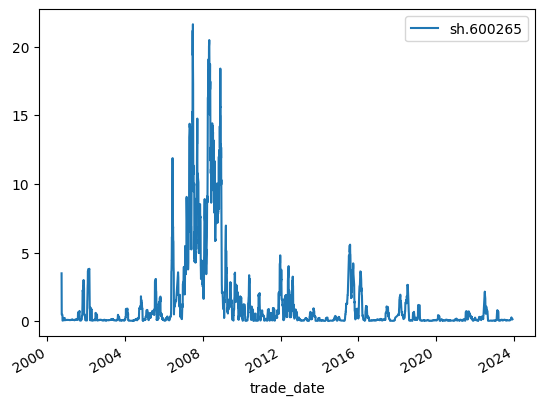

In [7]:
AMB_df.plot()